In [1]:
import sys
import os
import json
from datetime import date, datetime

from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, RMSprop
from keras import layers, Sequential
import keras_tuner as kt
import keras.backend as K

from src.comparison_model import create_comparison_network
from src.feature_extractor import create_vgg19_feature_extractor
from src.utils  import safe_save_training_results, plot_model_metrics
from src.dataset import prepare_dataset


# Configs
sys.path.append('../../')
question_id = 4

Using TensorFlow backend


In [2]:
def build_model(hp):
    # Hyperparameters of image preprocessing and augmentation
    img_aug_layers = Sequential(
        [
            layers.RandomZoom(0.2),
            layers.RandomRotation(0.2),
            layers.RandomContrast(0.4)
        ]
    )
    
    # Hyperparameters of Feature Extractor
    feature_extractor=create_vgg19_feature_extractor()
    
    # Hyperparameters of Fusion Network of Comparison Network
    num_conv_layers=hp.Fixed('num_conv_layers', value=3)
    conv_filters_list=[hp.Int('conv_filters_{}'.format(i), min_value=256, max_value=512, step=128) for i in range(num_conv_layers)]
    conv_kernel_size_list= [hp.Fixed('conv_kernel_size_{}'.format(i), value=3) for i in range(num_conv_layers)]
    conv_activation_list=[hp.Choice('conv_activation_{}'.format(i), values=['relu', 'linear']) for i in range(num_conv_layers)]
    conv_padding_list=[hp.Choice('conv_padding_{}'.format(i), values=['valid', 'same']) for i in range(num_conv_layers)]
   
    # Build model
    comparison_network = create_comparison_network(img_size=(224, 224),
                                                   feature_extractor=feature_extractor,
                                                   image_augmentation_layers=img_aug_layers,
                                                   num_conv_layers=num_conv_layers,
                                                   conv_filters_list=conv_filters_list,
                                                   conv_kernel_size_list=conv_kernel_size_list,
                                                   conv_activation_list=conv_activation_list,
                                                   conv_padding_list=conv_padding_list)
    
    # Hyperparameters of Training
    optimizers = {
        'adam': Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5])),
        'sgd': SGD(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5])),
        'rmsprop': RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5]))
    }

    comparison_network.compile(optimizer=optimizers[hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])],
                               loss='binary_crossentropy',
                               metrics=['accuracy'])
    
    return comparison_network

build_model(kt.HyperParameters())

In [3]:
images_dir = '../../data/Mapillary_data/Sample_web_green/' 
duel_results_path = f'../../data/duel_results/duels_question_{question_id}.csv'
img_size = 224  # 224 for VGG19
shuffle_seed = 1  # Seed for reproducibility

(x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_dataset(img_size,duel_results_path, images_dir, model_type='comparison', shuffle=True, shuffle_seed=shuffle_seed)

Number of duels before removing the duplicated duels: 4452
Number of duels after removing the duplicated duels: 4400


Processing Duels: 100%|██████████| 4400/4400 [01:08<00:00, 64.64it/s]


Dataset shuffled. Random seed:  1
Dataset split into train, validation and test sets. Split ratio:  [0.6, 0.2]


In [4]:
today = date.today().strftime("%y%m%d")
time = datetime.now().strftime("%H%M%S")
exec_datetime = int(f'{today}{time}')
print('Execution datetime: {}'.format(exec_datetime))

directory = rf'D:\zluo033\DNNTraining\results\comparison_models_from_scratch\q{question_id}_model_training\hyperparameter_tuning\BayesianOptimization_rs{shuffle_seed}'
project_name = "BayesianOptimization_{}".format(exec_datetime)

tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=100,
    # num_initial_points=None,
    # alpha=0.0001,
    # beta=2.6,
    # seed=None,
    # hyperparameters=None,
    # tune_new_entries=True,
    # allow_new_entries=True,
    # max_retries_per_trial=2,
    # max_consecutive_failed_trials=3,
    overwrite=False,
    directory=directory,
    project_name=project_name,
)

tuner.search_space_summary()  # Print search space summary

Execution datetime: 231029190302
Search space summary
Default search space size: 15
num_conv_layers (Fixed)
{'conditions': [], 'value': 3}
conv_filters_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
conv_filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
conv_filters_2 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
conv_kernel_size_0 (Fixed)
{'conditions': [], 'value': 3}
conv_kernel_size_1 (Fixed)
{'conditions': [], 'value': 3}
conv_kernel_size_2 (Fixed)
{'conditions': [], 'value': 3}
conv_activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'linear'], 'ordered': False}
conv_activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'linear'], 'ordered': False}
conv_activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['

In [5]:
tuner.search(x=x_train,
             y=y_train,
             epochs=50,
             batch_size=32,
             validation_data=(x_val, y_val),
             callbacks=[EarlyStopping(monitor='val_accuracy', 
                                      patience=10, 
                                      baseline=0.70,
                                      restore_best_weights=True)])

Trial 100 Complete [00h 08m 41s]
val_accuracy: 0.7136363387107849

Best val_accuracy So Far: 0.737500011920929
Total elapsed time: 12h 08m 00s


In [6]:
# Save search space summary to file
project_dir = f'{directory}/{project_name}'
os.makedirs(project_dir, exist_ok=True)

with open(f'{project_dir}/search_space.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    f.write(str(tuner.search_space_summary()))
    sys.stdout = original_stdout
    f.close()

In [7]:
# Query the Search Results
tuner.results_summary()

with open(f'{project_dir}/results_summary.txt', 'w') as f:
    original_stdout = sys.stdout
    sys.stdout = f
    f.write(str(tuner.results_summary()))
    sys.stdout = original_stdout
    f.close()

Results summary
Results in D:\zluo033\DNNTraining\results\comparison_models_from_scratch\q4_model_training\hyperparameter_tuning\BayesianOptimization_rs1\BayesianOptimization_231029190302
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 055 summary
Hyperparameters:
num_conv_layers: 3
conv_filters_0: 256
conv_filters_1: 512
conv_filters_2: 512
conv_kernel_size_0: 3
conv_kernel_size_1: 3
conv_kernel_size_2: 3
conv_activation_0: relu
conv_activation_1: relu
conv_activation_2: relu
conv_padding_0: same
conv_padding_1: valid
conv_padding_2: same
learning_rate: 0.0001
optimizer: rmsprop
Score: 0.737500011920929

Trial 065 summary
Hyperparameters:
num_conv_layers: 3
conv_filters_0: 256
conv_filters_1: 512
conv_filters_2: 512
conv_kernel_size_0: 3
conv_kernel_size_1: 3
conv_kernel_size_2: 3
conv_activation_0: relu
conv_activation_1: relu
conv_activation_2: relu
conv_padding_0: valid
conv_padding_1: valid
conv_padding_2: same
learning_rate: 0.0001
optimizer: rmsprop

In [8]:
# Save best 10 models and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=10)
best_models = tuner.get_best_models(num_models=10)

for i in range(len(best_models)):
    # save best models
    best_models[i].save(f'{project_dir}/best_model_{i + 1}.keras')

    # save the hyperparameters defined in the search space
    with open(f'{project_dir}/best_hps_{i + 1}.json', 'w') as f:
        json.dump(best_hps[i].values, f, indent=4)

    # save the model architecture alone
    best_model_architecture = build_model(best_hps[i])
    with open(f'{project_dir}/best_model_architecture_{i + 1}.json', 'w') as f:
        f.write(best_model_architecture.to_json(indent=4))
        f.close()

Retraining Model 1...
Epoch 1/50
42/42 [==============================] - 51s 1s/step - loss: 0.7556 - accuracy: 0.5284 - val_loss: 0.7091 - val_accuracy: 0.5807
Epoch 2/50
42/42 [==============================] - 44s 1s/step - loss: 0.6575 - accuracy: 0.6197 - val_loss: 0.6913 - val_accuracy: 0.6284
Epoch 3/50
42/42 [==============================] - 44s 1s/step - loss: 0.6204 - accuracy: 0.6606 - val_loss: 0.6756 - val_accuracy: 0.6591
Epoch 4/50
42/42 [==============================] - 43s 1s/step - loss: 0.5895 - accuracy: 0.6875 - val_loss: 0.6358 - val_accuracy: 0.6807
Epoch 5/50
42/42 [==============================] - 43s 1s/step - loss: 0.5793 - accuracy: 0.7015 - val_loss: 0.5969 - val_accuracy: 0.6932
Epoch 6/50
42/42 [==============================] - 43s 1s/step - loss: 0.5503 - accuracy: 0.7239 - val_loss: 0.5999 - val_accuracy: 0.7011
Epoch 7/50
42/42 [==============================] - 43s 1s/step - loss: 0.5485 - accuracy: 0.7201 - val_loss: 0.6537 - val_accuracy: 0.704

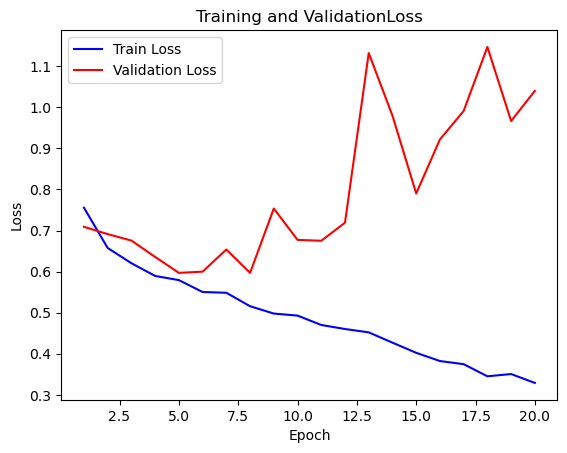

Figure Training and ValidationAccuracy saved!


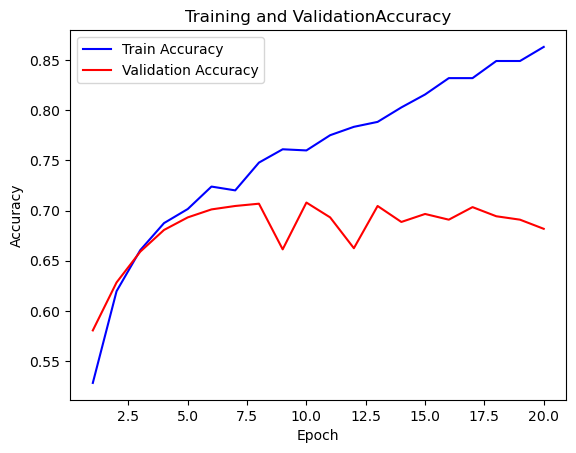

Model 1 results saved.
Retraining Model 2...
Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 0.8453 - accuracy: 0.5348 - val_loss: 0.6701 - val_accuracy: 0.6068
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6543 - accuracy: 0.6068 - val_loss: 0.9524 - val_accuracy: 0.5159
Epoch 3/50
42/42 [==============================] - 44s 1s/step - loss: 0.6209 - accuracy: 0.6530 - val_loss: 0.6325 - val_accuracy: 0.6659
Epoch 4/50
42/42 [==============================] - 45s 1s/step - loss: 0.6025 - accuracy: 0.6731 - val_loss: 0.5637 - val_accuracy: 0.7080
Epoch 5/50
42/42 [==============================] - 43s 1s/step - loss: 0.5754 - accuracy: 0.6989 - val_loss: 0.6444 - val_accuracy: 0.6614
Epoch 6/50
42/42 [==============================] - 44s 1s/step - loss: 0.5626 - accuracy: 0.7170 - val_loss: 0.9621 - val_accuracy: 0.6682
Epoch 7/50
42/42 [==============================] - 43s 1s/step - loss: 0.5457 - accuracy: 0.7269 - val_loss: 0.632

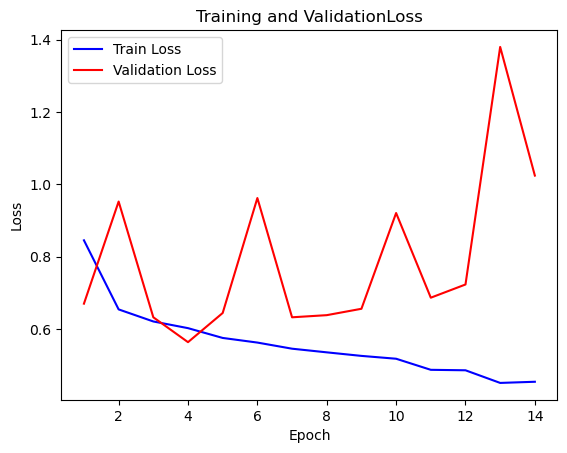

Figure Training and ValidationAccuracy saved!


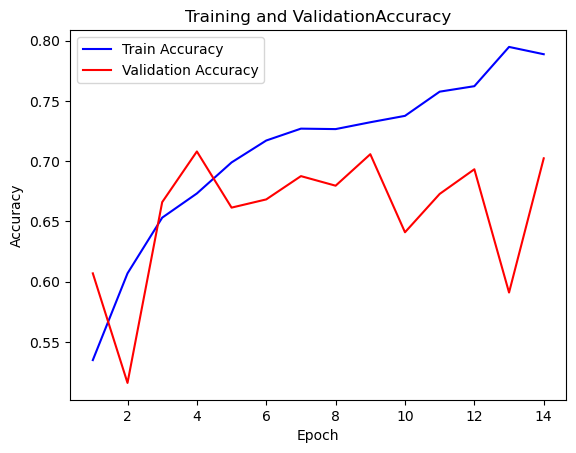

Model 2 results saved.
Retraining Model 3...
Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 0.8032 - accuracy: 0.5519 - val_loss: 0.6795 - val_accuracy: 0.5795
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6405 - accuracy: 0.6375 - val_loss: 0.7117 - val_accuracy: 0.5716
Epoch 3/50
42/42 [==============================] - 43s 1s/step - loss: 0.6149 - accuracy: 0.6652 - val_loss: 0.6462 - val_accuracy: 0.6341
Epoch 4/50
42/42 [==============================] - 43s 1s/step - loss: 0.5798 - accuracy: 0.6955 - val_loss: 0.7049 - val_accuracy: 0.6375
Epoch 5/50
42/42 [==============================] - 44s 1s/step - loss: 0.5695 - accuracy: 0.7042 - val_loss: 0.6328 - val_accuracy: 0.6409
Epoch 6/50
42/42 [==============================] - 43s 1s/step - loss: 0.5580 - accuracy: 0.7114 - val_loss: 0.6086 - val_accuracy: 0.6648
Epoch 7/50
42/42 [==============================] - 43s 1s/step - loss: 0.5242 - accuracy: 0.7379 - val_loss: 0.769

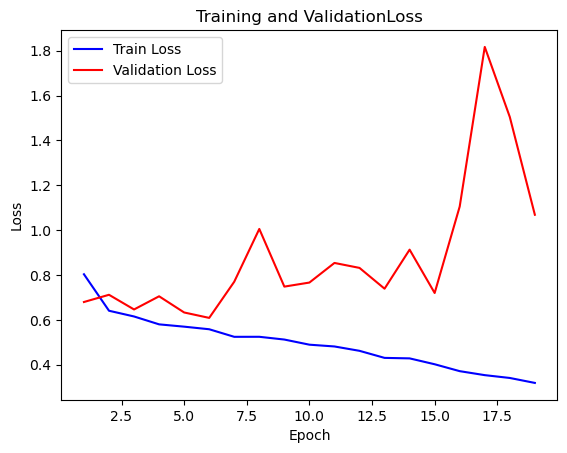

Figure Training and ValidationAccuracy saved!


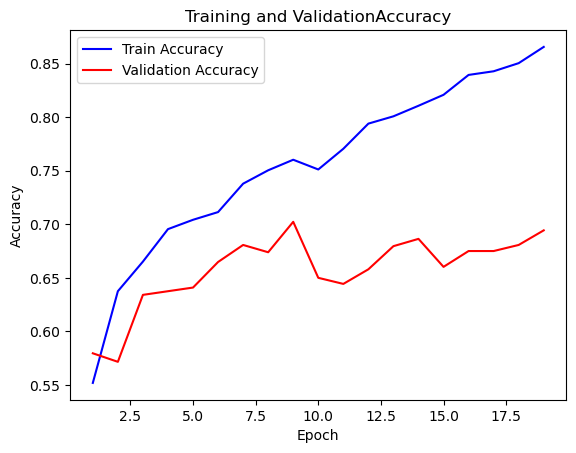

Model 3 results saved.
Retraining Model 4...
Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 0.8047 - accuracy: 0.5193 - val_loss: 0.7123 - val_accuracy: 0.5227
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6718 - accuracy: 0.5932 - val_loss: 0.6850 - val_accuracy: 0.6227
Epoch 3/50
42/42 [==============================] - 43s 1s/step - loss: 0.6414 - accuracy: 0.6330 - val_loss: 0.6287 - val_accuracy: 0.6830
Epoch 4/50
42/42 [==============================] - 43s 1s/step - loss: 0.5934 - accuracy: 0.6807 - val_loss: 0.6265 - val_accuracy: 0.6682
Epoch 5/50
42/42 [==============================] - 44s 1s/step - loss: 0.5888 - accuracy: 0.6856 - val_loss: 0.6049 - val_accuracy: 0.6670
Epoch 6/50
42/42 [==============================] - 43s 1s/step - loss: 0.5768 - accuracy: 0.6966 - val_loss: 0.6020 - val_accuracy: 0.6761
Epoch 7/50
42/42 [==============================] - 43s 1s/step - loss: 0.5533 - accuracy: 0.7201 - val_loss: 0.833

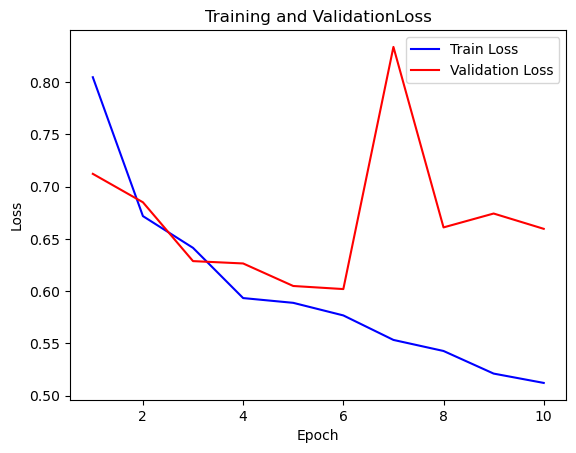

Figure Training and ValidationAccuracy saved!


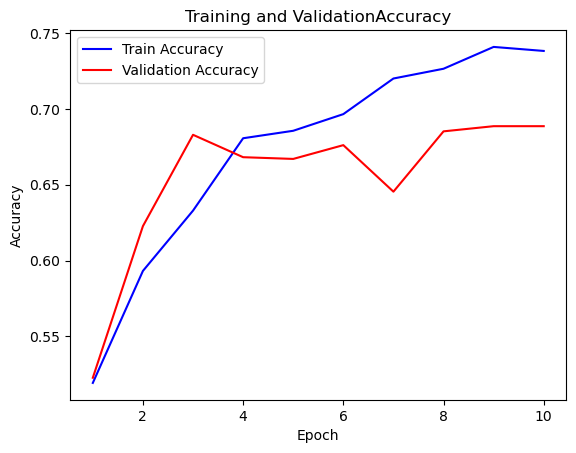

Model 4 results saved.
Retraining Model 5...
Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 0.8495 - accuracy: 0.5250 - val_loss: 0.6627 - val_accuracy: 0.6295
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6552 - accuracy: 0.6011 - val_loss: 0.9364 - val_accuracy: 0.6580
Epoch 3/50
42/42 [==============================] - 43s 1s/step - loss: 0.6218 - accuracy: 0.6667 - val_loss: 0.6843 - val_accuracy: 0.5909
Epoch 4/50
42/42 [==============================] - 44s 1s/step - loss: 0.5987 - accuracy: 0.6913 - val_loss: 0.6280 - val_accuracy: 0.6648
Epoch 5/50
42/42 [==============================] - 44s 1s/step - loss: 0.5664 - accuracy: 0.7045 - val_loss: 0.6263 - val_accuracy: 0.7000
Epoch 6/50
42/42 [==============================] - 44s 1s/step - loss: 0.5590 - accuracy: 0.7064 - val_loss: 0.6088 - val_accuracy: 0.6909
Epoch 7/50
42/42 [==============================] - 43s 1s/step - loss: 0.5369 - accuracy: 0.7394 - val_loss: 0.613

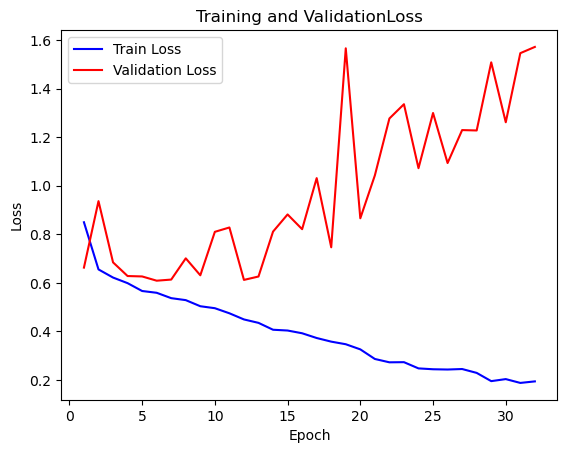

Figure Training and ValidationAccuracy saved!


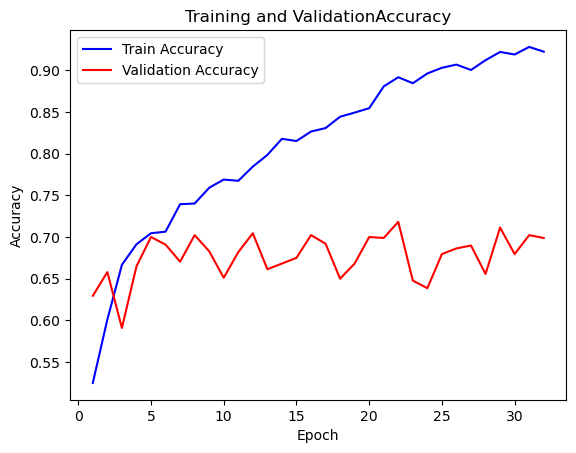

Model 5 results saved.
Retraining Model 6...
Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 0.8377 - accuracy: 0.5231 - val_loss: 0.6650 - val_accuracy: 0.5966
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6527 - accuracy: 0.6167 - val_loss: 0.6355 - val_accuracy: 0.6375
Epoch 3/50
42/42 [==============================] - 43s 1s/step - loss: 0.6065 - accuracy: 0.6655 - val_loss: 0.6304 - val_accuracy: 0.6602
Epoch 4/50
42/42 [==============================] - 43s 1s/step - loss: 0.5843 - accuracy: 0.7030 - val_loss: 0.7087 - val_accuracy: 0.6443
Epoch 5/50
42/42 [==============================] - 43s 1s/step - loss: 0.5742 - accuracy: 0.7114 - val_loss: 0.6921 - val_accuracy: 0.6261
Epoch 6/50
42/42 [==============================] - 43s 1s/step - loss: 0.5488 - accuracy: 0.7273 - val_loss: 0.8389 - val_accuracy: 0.6386
Epoch 7/50
42/42 [==============================] - 44s 1s/step - loss: 0.5321 - accuracy: 0.7337 - val_loss: 0.620

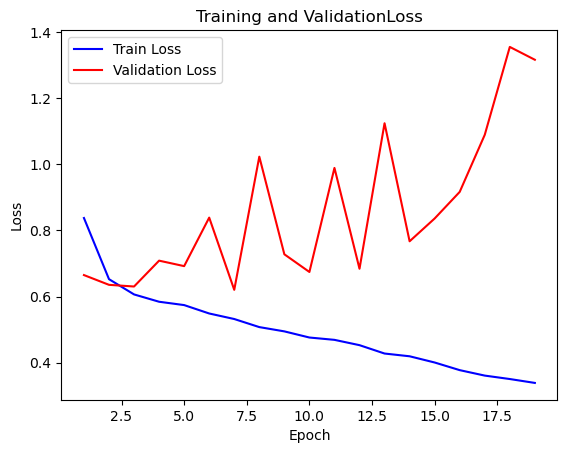

Figure Training and ValidationAccuracy saved!


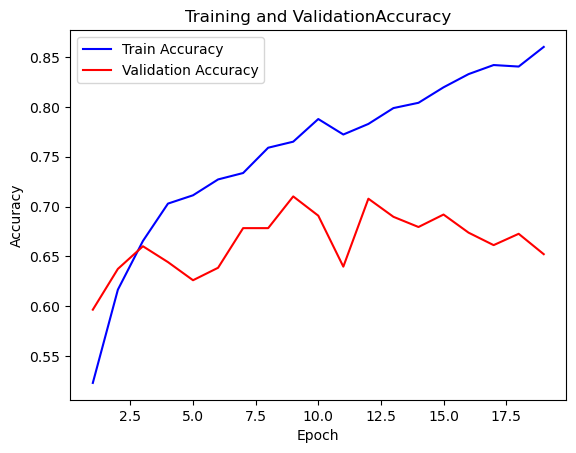

Model 6 results saved.
Retraining Model 7...
Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 0.8604 - accuracy: 0.5326 - val_loss: 0.8805 - val_accuracy: 0.5148
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6879 - accuracy: 0.5739 - val_loss: 0.6312 - val_accuracy: 0.6466
Epoch 3/50
42/42 [==============================] - 43s 1s/step - loss: 0.6207 - accuracy: 0.6598 - val_loss: 0.6116 - val_accuracy: 0.6705
Epoch 4/50
42/42 [==============================] - 43s 1s/step - loss: 0.5997 - accuracy: 0.6818 - val_loss: 0.6186 - val_accuracy: 0.6705
Epoch 5/50
42/42 [==============================] - 43s 1s/step - loss: 0.5787 - accuracy: 0.7064 - val_loss: 0.5894 - val_accuracy: 0.6818
Epoch 6/50
42/42 [==============================] - 43s 1s/step - loss: 0.5585 - accuracy: 0.7102 - val_loss: 0.5868 - val_accuracy: 0.6932
Epoch 7/50
42/42 [==============================] - 43s 1s/step - loss: 0.5528 - accuracy: 0.7318 - val_loss: 0.608

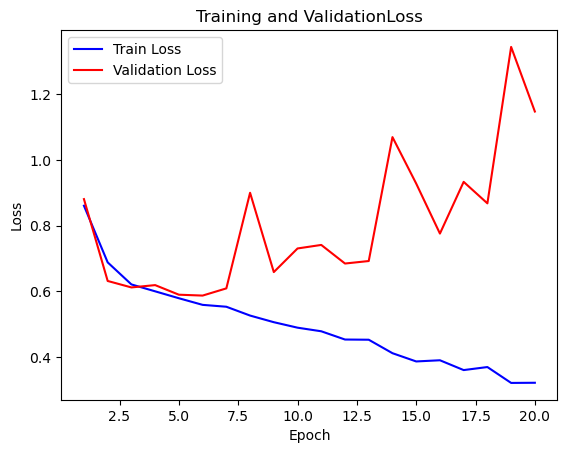

Figure Training and ValidationAccuracy saved!


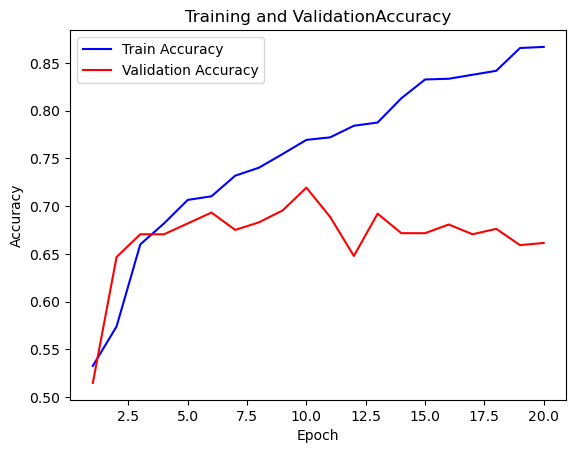

Model 7 results saved.
Retraining Model 8...
Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 0.7988 - accuracy: 0.5239 - val_loss: 0.6849 - val_accuracy: 0.5205
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6486 - accuracy: 0.6246 - val_loss: 1.1436 - val_accuracy: 0.6250
Epoch 3/50
42/42 [==============================] - 43s 1s/step - loss: 0.6233 - accuracy: 0.6625 - val_loss: 0.6981 - val_accuracy: 0.6920
Epoch 4/50
42/42 [==============================] - 44s 1s/step - loss: 0.5685 - accuracy: 0.7125 - val_loss: 0.6443 - val_accuracy: 0.6648
Epoch 5/50
42/42 [==============================] - 43s 1s/step - loss: 0.5628 - accuracy: 0.7064 - val_loss: 0.8283 - val_accuracy: 0.6852
Epoch 6/50
42/42 [==============================] - 43s 1s/step - loss: 0.5413 - accuracy: 0.7341 - val_loss: 0.8858 - val_accuracy: 0.6670
Epoch 7/50
42/42 [==============================] - 44s 1s/step - loss: 0.5243 - accuracy: 0.7337 - val_loss: 0.574

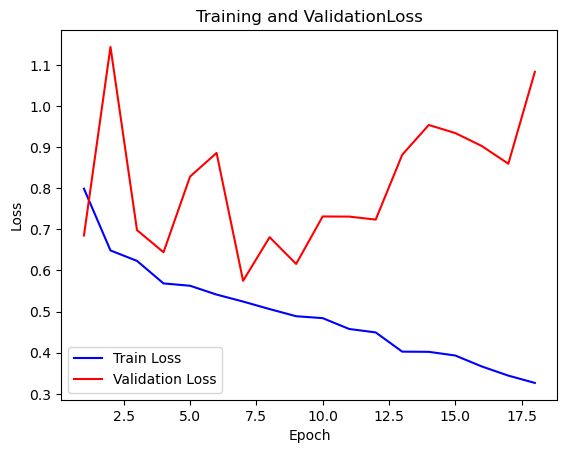

Figure Training and ValidationAccuracy saved!


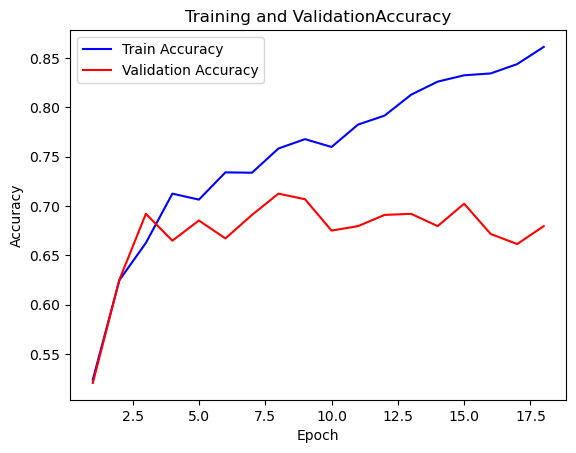

Model 8 results saved.
Retraining Model 9...
Epoch 1/50
42/42 [==============================] - 48s 1s/step - loss: 0.7795 - accuracy: 0.5398 - val_loss: 1.0543 - val_accuracy: 0.4943
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6732 - accuracy: 0.6144 - val_loss: 0.6505 - val_accuracy: 0.6227
Epoch 3/50
42/42 [==============================] - 43s 1s/step - loss: 0.6334 - accuracy: 0.6462 - val_loss: 0.5993 - val_accuracy: 0.6795
Epoch 4/50
42/42 [==============================] - 44s 1s/step - loss: 0.6019 - accuracy: 0.6659 - val_loss: 0.6040 - val_accuracy: 0.6614
Epoch 5/50
42/42 [==============================] - 43s 1s/step - loss: 0.5888 - accuracy: 0.6784 - val_loss: 0.9342 - val_accuracy: 0.6489
Epoch 6/50
42/42 [==============================] - 43s 1s/step - loss: 0.5809 - accuracy: 0.7023 - val_loss: 0.6323 - val_accuracy: 0.6795
Epoch 7/50
42/42 [==============================] - 43s 1s/step - loss: 0.5714 - accuracy: 0.7098 - val_loss: 0.837

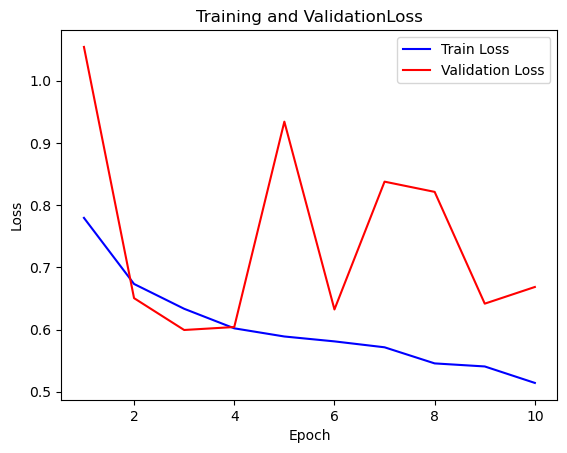

Figure Training and ValidationAccuracy saved!


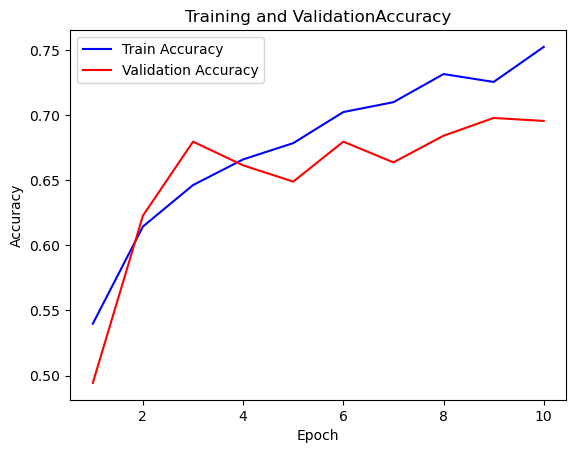

Model 9 results saved.
Retraining Model 10...
Epoch 1/50
42/42 [==============================] - 49s 1s/step - loss: 0.8318 - accuracy: 0.5504 - val_loss: 1.0665 - val_accuracy: 0.5136
Epoch 2/50
42/42 [==============================] - 43s 1s/step - loss: 0.6449 - accuracy: 0.6280 - val_loss: 0.6523 - val_accuracy: 0.6352
Epoch 3/50
42/42 [==============================] - 43s 1s/step - loss: 0.6143 - accuracy: 0.6705 - val_loss: 0.6375 - val_accuracy: 0.6727
Epoch 4/50
42/42 [==============================] - 43s 1s/step - loss: 0.5795 - accuracy: 0.6992 - val_loss: 0.5935 - val_accuracy: 0.6750
Epoch 5/50
42/42 [==============================] - 43s 1s/step - loss: 0.5641 - accuracy: 0.7102 - val_loss: 0.6948 - val_accuracy: 0.6670
Epoch 6/50
42/42 [==============================] - 43s 1s/step - loss: 0.5374 - accuracy: 0.7303 - val_loss: 0.8383 - val_accuracy: 0.6830
Epoch 7/50
42/42 [==============================] - 43s 1s/step - loss: 0.5268 - accuracy: 0.7485 - val_loss: 0.59

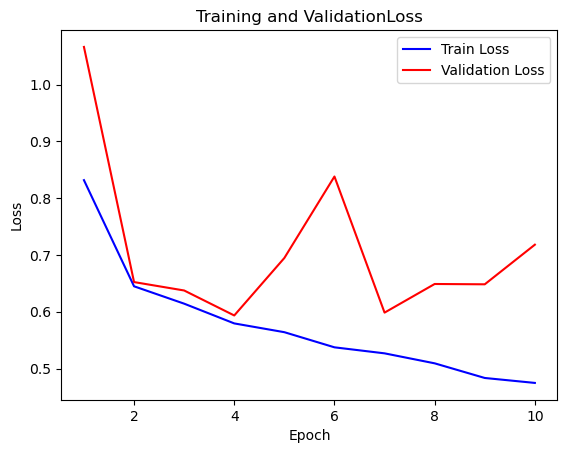

Figure Training and ValidationAccuracy saved!


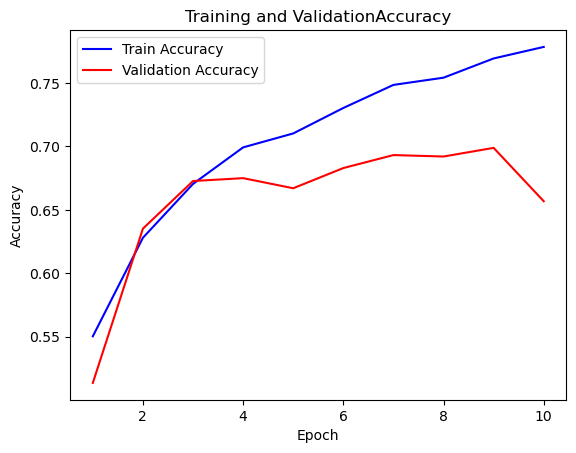

Model 10 results saved.


In [9]:
# Retrain the best 10 models
for i in range(len(best_models)):
    print('Retraining Model {}...'.format(i+1))
    
    model = build_model(best_hps[i])
    
    # Train the model
    history = model.fit(x=x_train, 
                        y=y_train, 
                        batch_size=64, 
                        epochs=50, 
                        verbose=1, 
                        callbacks=[EarlyStopping(monitor='val_accuracy', 
                                                 patience=10, 
                                                 baseline=0.70,
                                                 restore_best_weights=True)],
                        validation_data=(x_val, y_val))
    
    best_val_acc = max(history.history['val_accuracy'])
    print('Model {} retrained. Best validation accuracy: {}'.format(i+1, best_val_acc))
    
    # Save training results
    results_save_dir = '{}/Model_{}_Ranking_VGG19_BestValAcc{:.4f}'.format(project_dir, i+1, best_val_acc)
    
    safe_save_training_results(model=model, 
                               history=history, 
                               save_dir=results_save_dir)
    
    plot_model_metrics(history, ['loss', 'accuracy'], save_dir=results_save_dir)
    print('Model {} results saved.'.format(i+1))
    
    # Clear the session for the next training
    K.clear_session()